## Multiplier/Contestants

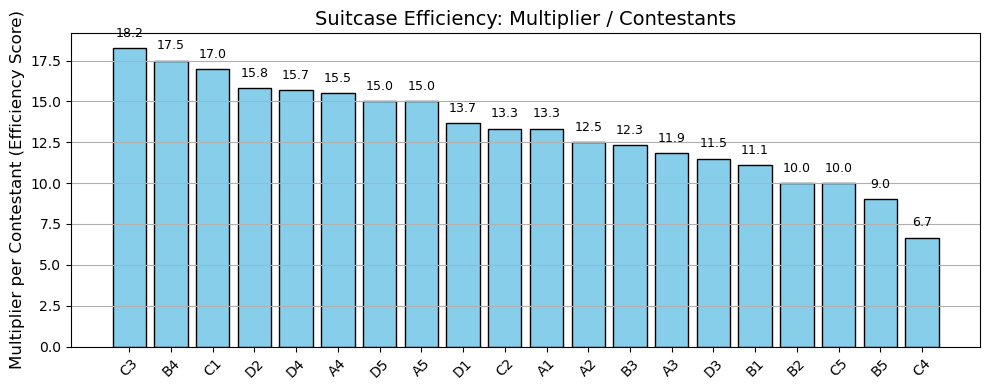

In [37]:
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
BASE_TREASURE = 10000
SECOND_COST = 50000
THIRD_COST = 100000
TOTAL_PLAYERS = 3200
suitcases = pd.DataFrame([
    {"id": "A1", "multiplier": 80, "contestants": 6},
    {"id": "A2", "multiplier": 50, "contestants": 4},
    {"id": "A3", "multiplier": 83, "contestants": 7},
    {"id": "A4", "multiplier": 31, "contestants": 2},
    {"id": "A5", "multiplier": 60, "contestants": 4},
    {"id": "B1", "multiplier": 89, "contestants": 8},
    {"id": "B2", "multiplier": 10, "contestants": 1},
    {"id": "B3", "multiplier": 37, "contestants": 3},
    {"id": "B4", "multiplier": 70, "contestants": 4},
    {"id": "B5", "multiplier": 90, "contestants": 10},
    {"id": "C1", "multiplier": 17, "contestants": 1},
    {"id": "C2", "multiplier": 40, "contestants": 3},
    {"id": "C3", "multiplier": 73, "contestants": 4},
    {"id": "C4", "multiplier": 100, "contestants": 15},
    {"id": "C5", "multiplier": 20, "contestants": 2},
    {"id": "D1", "multiplier": 41, "contestants": 3},
    {"id": "D2", "multiplier": 79, "contestants": 5},
    {"id": "D3", "multiplier": 23, "contestants": 2},
    {"id": "D4", "multiplier": 47, "contestants": 3},
    {"id": "D5", "multiplier": 30, "contestants": 2},
])
suitcases["value_per_contestant"] = suitcases["multiplier"] / suitcases["contestants"]
suitcases_sorted = suitcases.sort_values(by="value_per_contestant", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 4))
bars = plt.bar(suitcases_sorted["id"], suitcases_sorted["value_per_contestant"], color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel("Multiplier per Contestant (Efficiency Score)", fontsize=12)
plt.title("Suitcase Efficiency: Multiplier / Contestants", fontsize=14)
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


## How Profit in each suitcase decrease againse chosen ratio

A1 A3 A5 B1 B4 B5 C3 C4 Desrease slower than others

their Multiplier/Contestants:

C3 B4    very high (largest)

A5 A1 A3 middle

B1       low

B5 C4    very low (smallest)


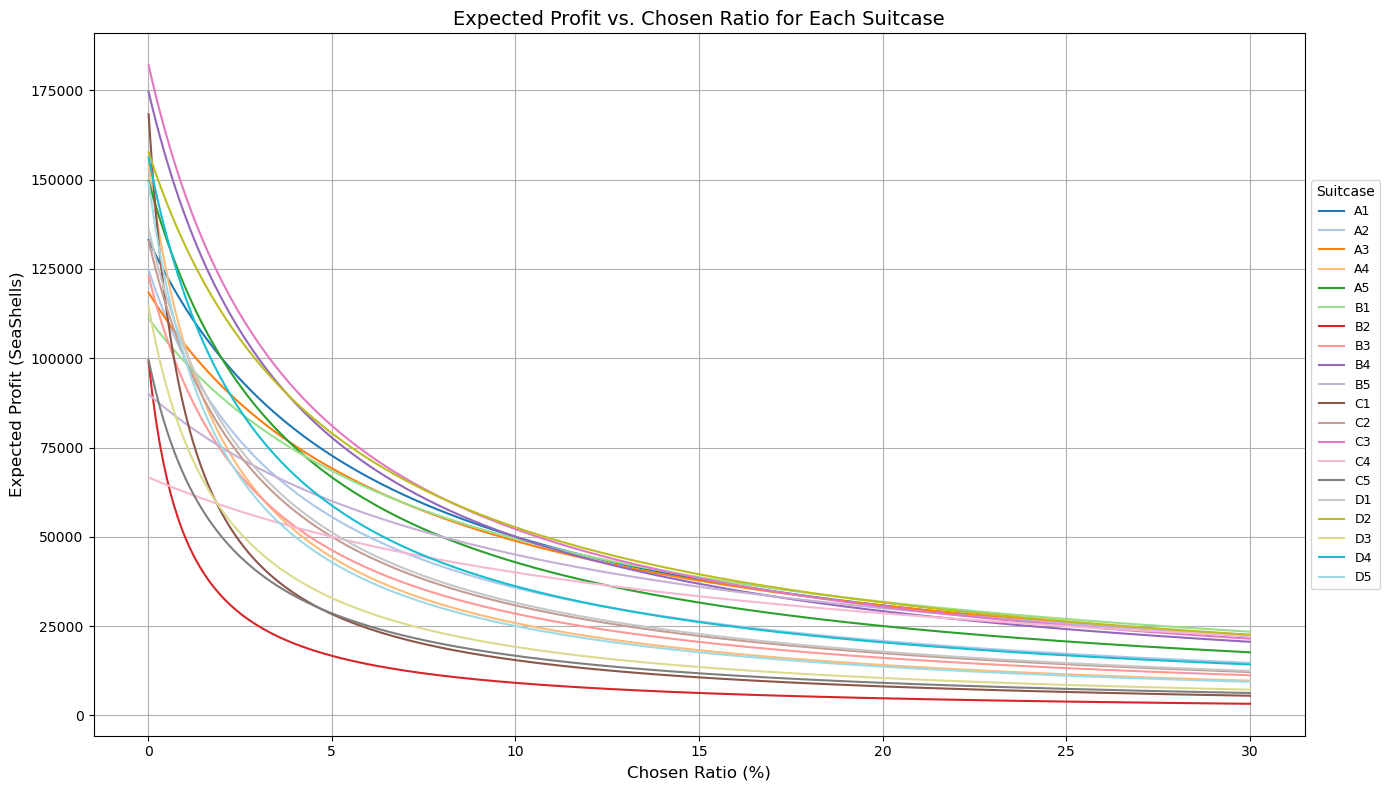

In [38]:
colors = cm.get_cmap('tab20', len(container_curves))
plt.figure(figsize=(14, 8))
for idx, (container_id, profits) in enumerate(container_curves.items()):
    plt.plot(popularity_range, profits, label=container_id, color=colors(idx))
plt.title("Expected Profit vs. Chosen Ratio for Each Suitcase", fontsize=14)
plt.xlabel("Chosen Ratio (%)", fontsize=12)
plt.ylabel("Expected Profit (SeaShells)", fontsize=12)
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Suitcase", fontsize=9)
plt.tight_layout()
plt.show()

## QRE Model (same method as round 2) applied to show top picks

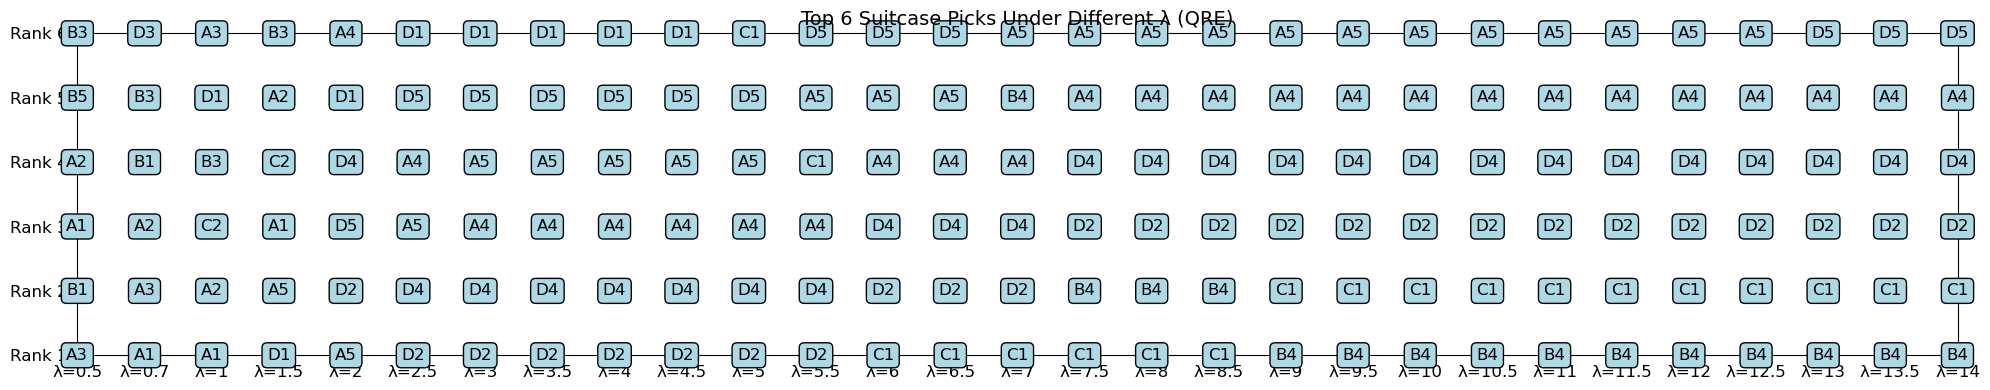

In [50]:
# Use utility = multiplier / contestants as the basis for QRE
suitcases["utility"] = suitcases["multiplier"] / suitcases["contestants"]

# Define QRE softmax function
def quantal_response(utility, lam):
    scaled_util = lam * utility
    exp_util = np.exp(scaled_util - np.max(scaled_util))  # Stability
    return exp_util / exp_util.sum()

# Lambda values to explore
lambda_values = [0.5,0.7,1,1.5,2,2.5,3,3.5,4,4.5, 5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14]

# Store top picks per lambda
top_picks_by_lambda = {}

for lam in lambda_values:
    # Compute popularity probabilities using QRE
    suitcases["popularity_prob"] = quantal_response(suitcases["utility"], lam)
    suitcases["popularity_pct"] = suitcases["popularity_prob"] * 100
    
    # Compute expected profit per suitcase
    suitcases["expected_profit"] = (BASE_TREASURE * suitcases["multiplier"]) / (
        suitcases["contestants"] + suitcases["popularity_pct"]
    )
    
    # Get top 6 suitcases by expected profit
    top6 = suitcases.sort_values(by="expected_profit", ascending=False).head(6)[["id", "expected_profit"]]
    top_picks_by_lambda[lam] = top6.reset_index(drop=True)

# Combine all results into one DataFrame
combined_top_picks = pd.concat(
    {f"λ={lam}": df for lam, df in top_picks_by_lambda.items()},
    names=["Lambda", "Rank"]
).reset_index()


# Top 6 suitcase picks under different lambda values

plt.figure(figsize=(20, 4))
lambda_levels = sorted(top_picks_by_lambda.keys())

# Plot suitcase IDs as annotations in a matrix
for i, lam in enumerate(lambda_levels):
    picks = top_picks_by_lambda[lam]
    for j, (_, row) in enumerate(picks.iterrows()):
        plt.text(i, 5 - j, row["id"], fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

# Axis setup
plt.xticks(ticks=range(len(lambda_levels)), labels=[f"λ={lam}" for lam in lambda_levels], fontsize=12)
plt.yticks(ticks=range(6), labels=[f"Rank {6 - i}" for i in range(6)], fontsize=12)
plt.gca().invert_yaxis()
plt.title("Top 6 Suitcase Picks Under Different λ (QRE)", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


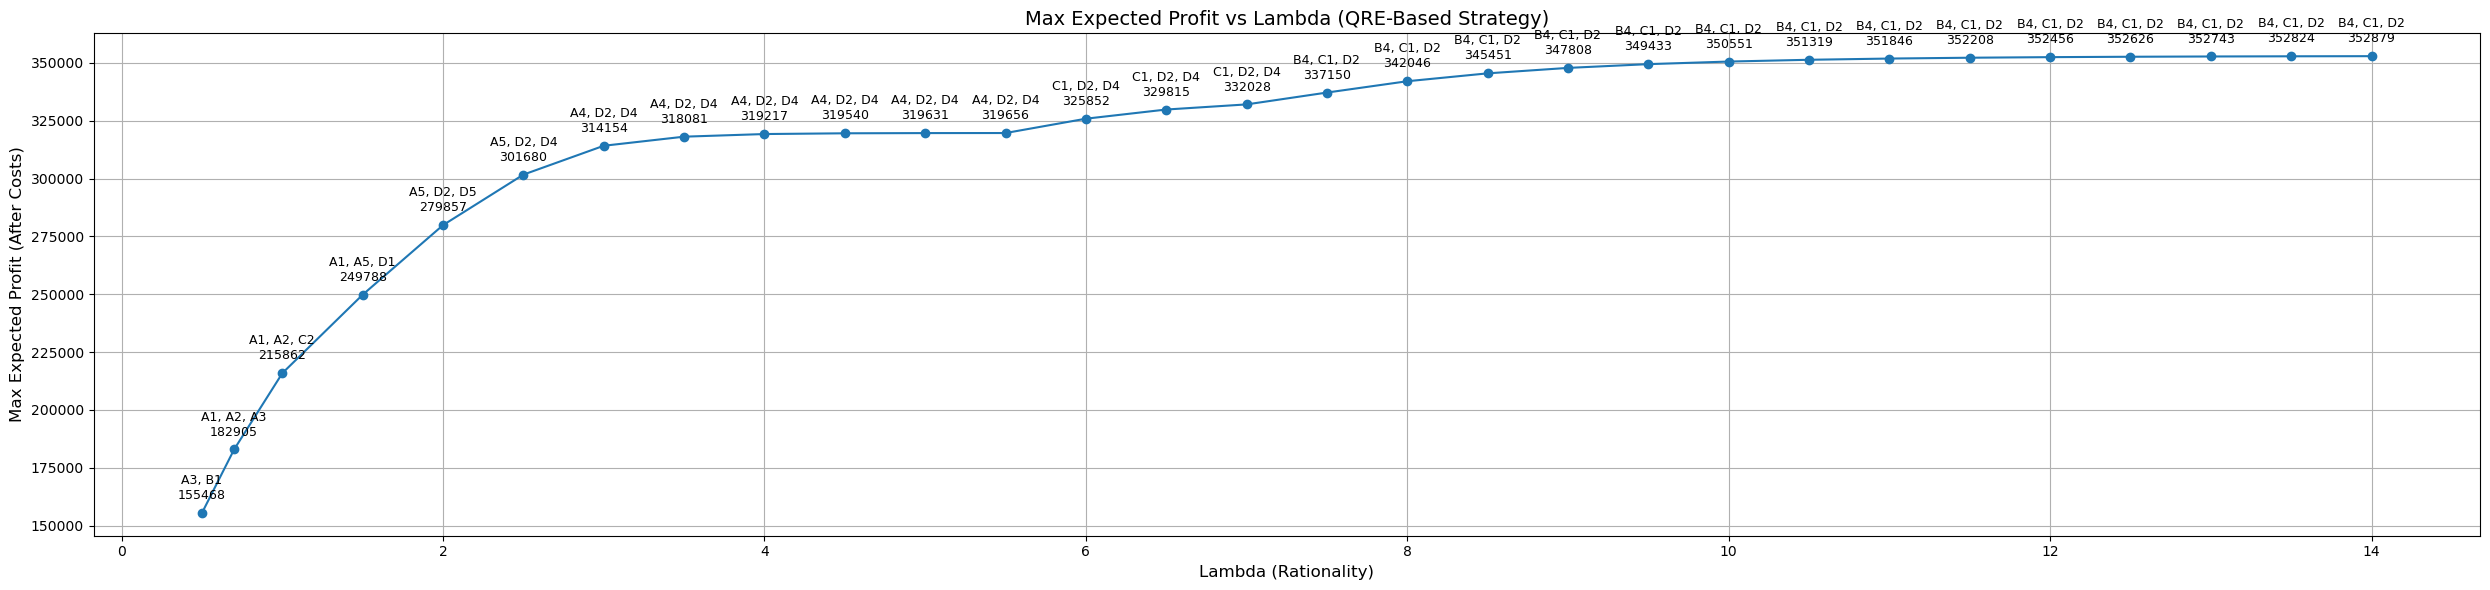

In [51]:
# Calculate the max profit strategy (1, 2, or 3 picks) for each lambda
from itertools import combinations

lambda_max_profits = []
lambda_best_combos = []

for lam in lambda_levels:
    suitcases["popularity_prob"] = quantal_response(suitcases["utility"], lam)
    suitcases["popularity_pct"] = suitcases["popularity_prob"] * 100
    suitcases["expected_profit"] = (BASE_TREASURE * suitcases["multiplier"]) / (
        suitcases["contestants"] + suitcases["popularity_pct"]
    )
    
    max_profit = -np.inf
    best_combo = []

    for k in [1, 2, 3]:
        for combo in combinations(suitcases.itertuples(), k):
            profits = [s.expected_profit for s in combo]
            ids = [s.id for s in combo]
            total = profits[0]
            if k >= 2:
                total += profits[1] - SECOND_COST
            if k == 3:
                total += profits[2] - THIRD_COST
            if total > max_profit:
                max_profit = total
                best_combo = ids

    lambda_max_profits.append(max_profit)
    lambda_best_combos.append(best_combo)

# Plotting max profit vs lambda
plt.figure(figsize=(25, 6))
plt.plot(lambda_levels, lambda_max_profits, marker='o', linestyle='-')
for i, lam in enumerate(lambda_levels):
    label = ', '.join(lambda_best_combos[i])
    plt.annotate(f"{label}\n{int(lambda_max_profits[i])}", (lam, lambda_max_profits[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.title("Max Expected Profit vs Lambda (QRE-Based Strategy)", fontsize=14)
plt.xlabel("Lambda (Rationality)", fontsize=12)
plt.ylabel("Max Expected Profit (After Costs)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Use result of round 2

## Result of Round 2

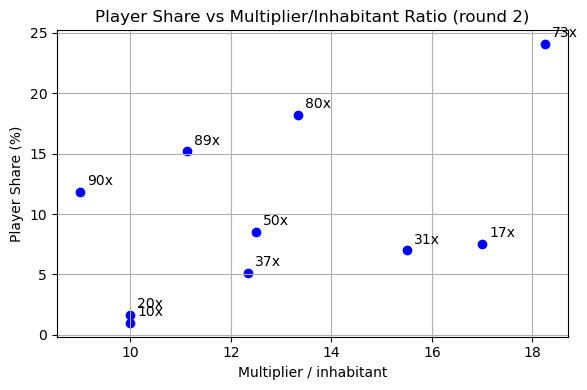

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# round 2
data = {
    'Label': ['10x', '17x', '20x', '31x', '37x', '50x', '73x', '80x', '89x', '90x'],
    'Multiplier': [10, 17, 20, 31, 37, 50, 73, 80, 89, 90],
    'Inhabitants': [1, 1, 2, 2, 3, 4, 4, 6, 8, 10],
    'PlayerShare (%)': [0.998, 7.539, 1.614, 6.987, 5.118, 8.516, 24.060, 18.178, 15.184, 11.807]
}

df = pd.DataFrame(data)

# multiplier/inhabitant ratio
df['Multiplier/Inhabitant'] = df['Multiplier'] / df['Inhabitants']

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(df['Multiplier/Inhabitant'], df['PlayerShare (%)'], color='blue')

# Annotate each point
for i, row in df.iterrows():
    plt.annotate(row['Label'], (row['Multiplier/Inhabitant'], row['PlayerShare (%)']), textcoords="offset points", xytext=(5,5), ha='left')

plt.title('Player Share vs Multiplier/Inhabitant Ratio (round 2)')
plt.xlabel('Multiplier / inhabitant')
plt.ylabel('Player Share (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# Round 1 popularity by multiplier
round1_distribution = {
    "10": 0.00998,
    "17": 0.07539,
    "20": 0.01614,
    "31": 0.06987,
    "37": 0.05118,
    "50": 0.08516,
    "73": 0.24060,
    "80": 0.18178,
    "89": 0.15184,
    "90": 0.11807
}

# Assign estimated popularity % based on closest multiplier from round 1
def get_estimated_popularity(multiplier):
    available = np.array([int(k) for k in round1_distribution.keys()])
    closest = available[np.abs(available - multiplier).argmin()]
    return round1_distribution[str(closest)]

suitcases["estimated_popularity_pct"] = suitcases["multiplier"].apply(get_estimated_popularity) * 100

# Calculate expected profit under this model
suitcases["profit_from_round1_model"] = (BASE_TREASURE * suitcases["multiplier"]) / (
    suitcases["contestants"] + suitcases["estimated_popularity_pct"]
)

# Sort top 10 based on this model
top_from_round1_model = suitcases.sort_values(by="profit_from_round1_model", ascending=False).reset_index(drop=True)
top_from_round1_model[["id", "multiplier", "contestants", "estimated_popularity_pct", "profit_from_round1_model"]].head(10)


,id,multiplier,contestants,estimated_popularity_pct,profit_from_round1_model
0,D3,23,2,1.614,63641.394577
1,C5,20,2,1.614,55340.343110
2,D1,41,3,5.118,50505.050505
3,B2,10,1,0.998,50050.050050
4,C2,40,3,5.118,49273.220005
5,A5,60,4,8.516,47938.638543
6,B3,37,3,5.118,45577.728505
7,B5,90,10,11.807,41271.151465
8,D4,47,3,8.516,40812.782216
9,A2,50,4,8.516,39948.865452


# Combine QRE and Round 1 behavior for a hybrid prediction model

In [24]:
# Step 1: Compute utility for QRE
suitcases["utility"] = suitcases["multiplier"] / suitcases["contestants"]

# Step 2: Get softmax probabilities from QRE
def quantal_response(utility, lam):
    scaled_util = lam * utility
    exp_util = np.exp(scaled_util - np.max(scaled_util))  # numerical stability
    return exp_util / exp_util.sum()

# Choose a moderate rationality level
lambda_val = 2.0
qre_probs = quantal_response(suitcases["utility"], lambda_val)

# Step 3: Normalize Round 1 behavior probabilities
first_round_data = {
    10: 0.998,
    17: 7.539,
    20: 1.614,
    31: 6.987,
    37: 5.118,
    50: 8.516,
    73: 24.060,
    80: 18.178,
    89: 15.184,
    90: 11.807
}
total_percent = sum(first_round_data.values())
round1_probs = {k: v / total_percent for k, v in first_round_data.items()}
behavioral_probs = suitcases["multiplier"].map(round1_probs).fillna(0).values

# Step 4: Combine QRE and Round 1-based probabilities
# Weighted average: 50% QRE, 50% empirical behavior
combined_probs = 0.5 * qre_probs + 0.5 * behavioral_probs
combined_probs /= combined_probs.sum()  # normalize

# Step 5: Apply to suitcases
suitcases["hybrid_prob"] = combined_probs
suitcases["hybrid_pct"] = suitcases["hybrid_prob"] * 100

# Step 6: Calculate expected profit using hybrid popularity
suitcases["expected_profit"] = (BASE_TREASURE * suitcases["multiplier"]) / (
    suitcases["contestants"] + suitcases["hybrid_pct"]
)

# Sort and display
suitcases_hybrid = suitcases.sort_values(by="expected_profit", ascending=False).reset_index(drop=True)
suitcases_hybrid[["id", "multiplier", "contestants", "hybrid_pct", "expected_profit"]]


,id,multiplier,contestants,hybrid_pct,expected_profit
0,D2,79,5,2.808562e-01,149596.952590
1,A5,60,4,5.670390e-02,147903.326287
2,D4,47,3,2.151158e-01,146184.472504
3,D5,30,2,5.670390e-02,145864.458448
4,D1,41,3,3.939982e-03,136487.413997
5,C2,40,3,2.022854e-03,133243.489273
6,A3,83,7,1.056238e-04,118569.639460
7,D3,23,2,5.170726e-05,114997.026909
8,C5,20,2,8.069945e-01,71250.584810
9,B2,10,1,4.989976e-01,66711.248264


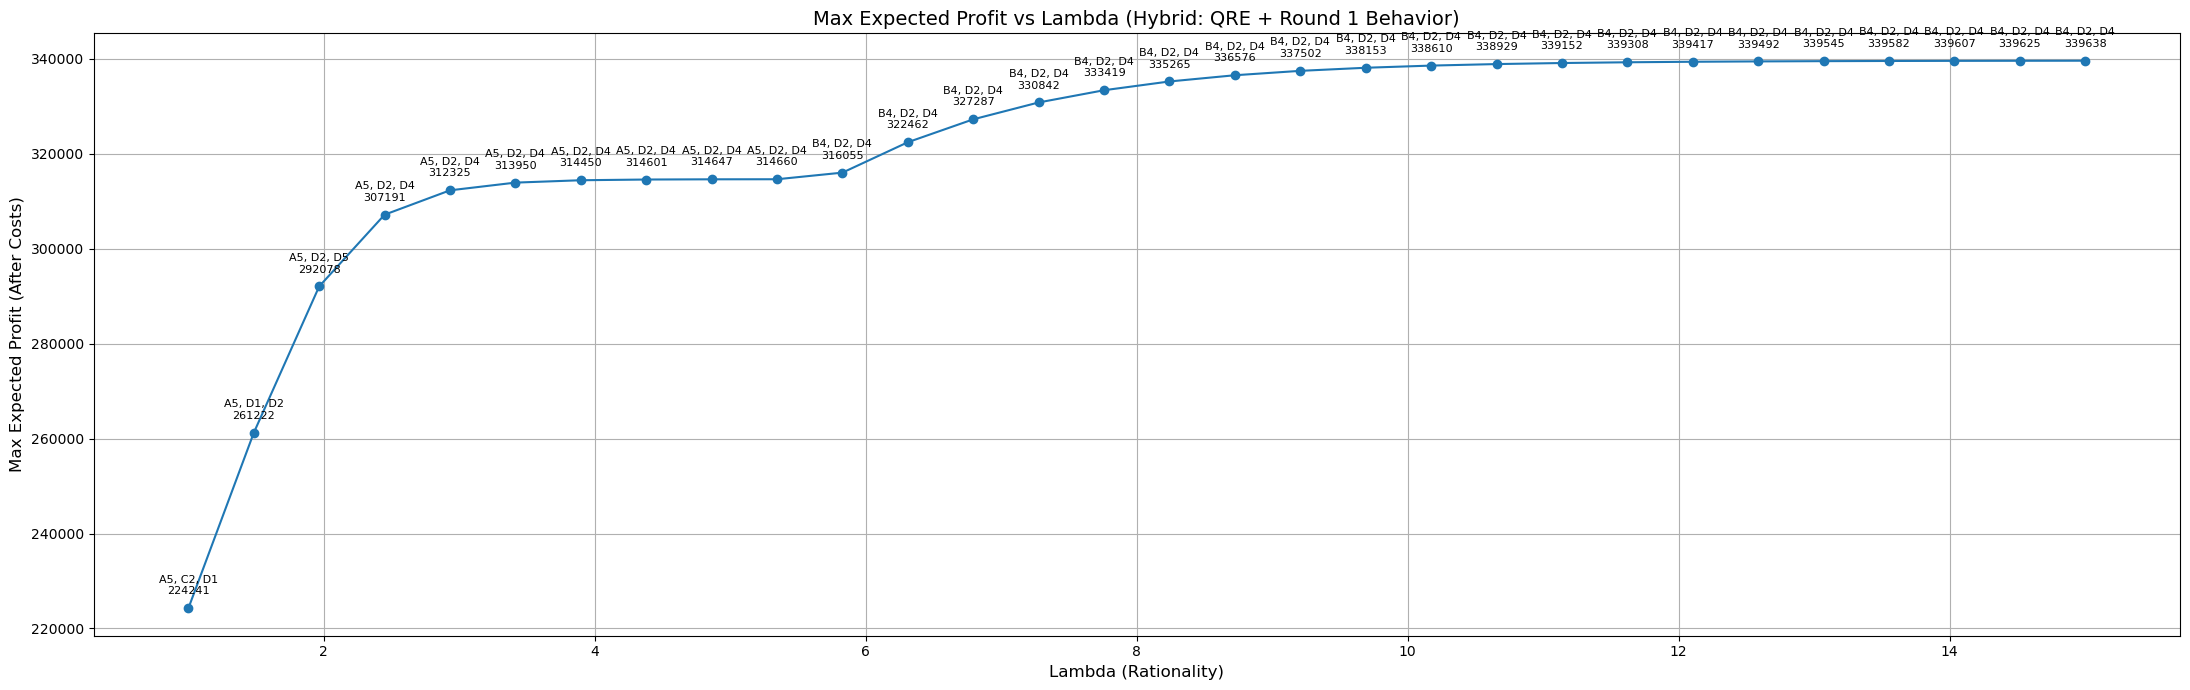

In [57]:
# Re-import necessary modules after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Constants
BASE_TREASURE = 10000
SECOND_COST = 50000
THIRD_COST = 100000

# Re-create suitcase data
suitcases = pd.DataFrame([
    {"id": "A1", "multiplier": 80, "contestants": 6},
    {"id": "A2", "multiplier": 50, "contestants": 4},
    {"id": "A3", "multiplier": 83, "contestants": 7},
    {"id": "A4", "multiplier": 31, "contestants": 2},
    {"id": "A5", "multiplier": 60, "contestants": 4},
    {"id": "B1", "multiplier": 89, "contestants": 8},
    {"id": "B2", "multiplier": 10, "contestants": 1},
    {"id": "B3", "multiplier": 37, "contestants": 3},
    {"id": "B4", "multiplier": 70, "contestants": 4},
    {"id": "B5", "multiplier": 90, "contestants": 10},
    {"id": "C1", "multiplier": 17, "contestants": 1},
    {"id": "C2", "multiplier": 40, "contestants": 3},
    {"id": "C3", "multiplier": 73, "contestants": 4},
    {"id": "C4", "multiplier": 100, "contestants": 15},
    {"id": "C5", "multiplier": 20, "contestants": 2},
    {"id": "D1", "multiplier": 41, "contestants": 3},
    {"id": "D2", "multiplier": 79, "contestants": 5},
    {"id": "D3", "multiplier": 23, "contestants": 2},
    {"id": "D4", "multiplier": 47, "contestants": 3},
    {"id": "D5", "multiplier": 30, "contestants": 2},
])

# QRE utility function
def quantal_response(utility, lam):
    scaled_util = lam * utility
    exp_util = np.exp(scaled_util - np.max(scaled_util))
    return exp_util / exp_util.sum()

# Round 1 data
first_round_data = {
    10: 0.998,
    17: 7.539,
    20: 1.614,
    31: 6.987,
    37: 5.118,
    50: 8.516,
    73: 24.060,
    80: 18.178,
    89: 15.184,
    90: 11.807
}
total_percent = sum(first_round_data.values())
round1_probs = {k: v / total_percent for k, v in first_round_data.items()}

# Lambda simulation
lambda_range = np.linspace(1, 15, 30)
max_profits = []
best_combos = []

for lam in lambda_range:
    suitcases["utility"] = suitcases["multiplier"] / suitcases["contestants"]
    qre_probs = quantal_response(suitcases["utility"], lam)
    behavior_probs = suitcases["multiplier"].map(round1_probs).fillna(0).values
    hybrid_probs = 0.5 * qre_probs + 0.5 * behavior_probs
    hybrid_probs /= hybrid_probs.sum()

    suitcases["hybrid_prob"] = hybrid_probs
    suitcases["hybrid_pct"] = hybrid_probs * 100
    suitcases["expected_profit"] = (BASE_TREASURE * suitcases["multiplier"]) / (
        suitcases["contestants"] + suitcases["hybrid_pct"]
    )

    best_profit = -np.inf
    best_ids = []

    for k in [1, 2, 3]:
        for combo in combinations(suitcases.itertuples(), k):
            profits = [s.expected_profit for s in combo]
            ids = [s.id for s in combo]
            total = profits[0]
            if k >= 2:
                total += profits[1] - SECOND_COST
            if k == 3:
                total += profits[2] - THIRD_COST
            if total > best_profit:
                best_profit = total
                best_ids = ids

    max_profits.append(best_profit)
    best_combos.append(best_ids)

# Plot
plt.figure(figsize=(22, 7))
plt.plot(lambda_range, max_profits, marker='o', linestyle='-')

for i, lam in enumerate(lambda_range):
    label = ', '.join(best_combos[i])
    plt.annotate(f"{label}\n{int(max_profits[i])}", (lam, max_profits[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.title("Max Expected Profit vs Lambda (Hybrid: QRE + Round 1 Behavior)", fontsize=14)
plt.xlabel("Lambda (Rationality)", fontsize=12)
plt.ylabel("Max Expected Profit (After Costs)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


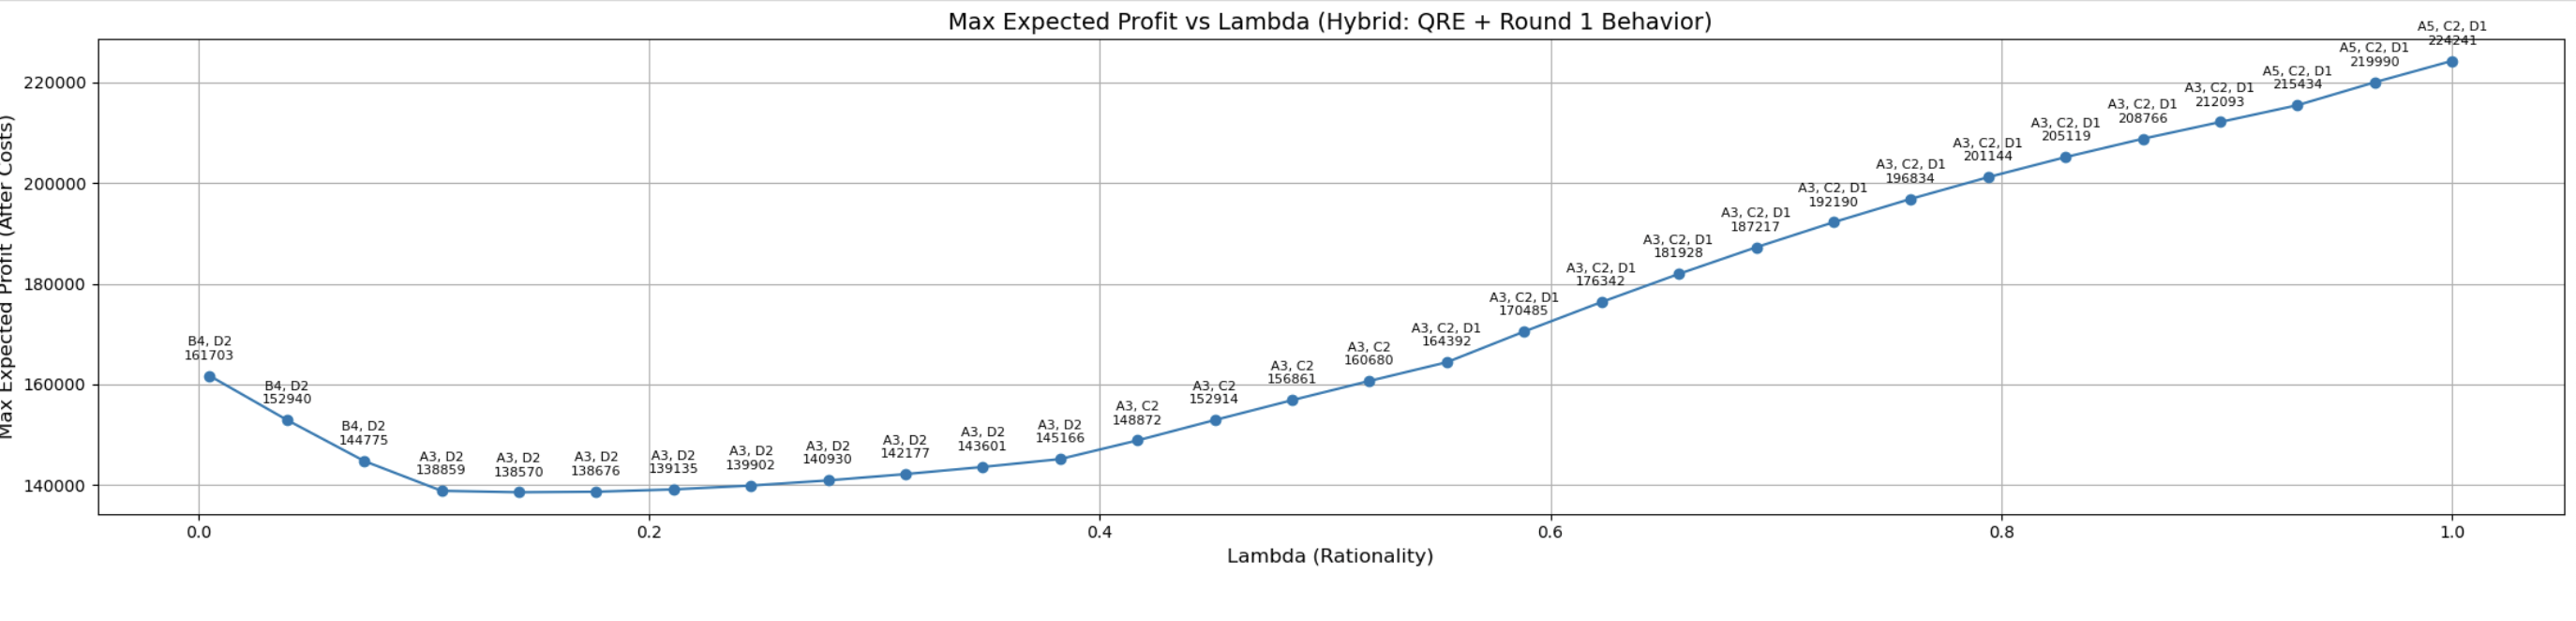

# result

D2 (79x) seems safe, it appears a lot in different labmda.

D5 A5 / C2 A1 / B2 B5 are pairs with same multiplier/contestants ratio (15 / 13.3 / 10), in round 2, the lowest 2 picked containers are same multiplier/contestants ration as well, diluted ppl who want this ratio, so maybe choose among the 3 pairs can have less ppl share one suitcase. (But not sure about this, since the sum of the lowest 2 picked containers is still the lowesrt.)